In [1]:
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from torch import nn

class GaussianDiffusion:
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.model = model
        self.device = device
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.set_timesteps(timesteps)

    def set_timesteps(self, timesteps):
        self.timesteps = timesteps
        self.beta = torch.linspace(self.beta_start, self.beta_end, timesteps).to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        print(f"🔧 Diffusion mise à jour : {timesteps} étapes")

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_hat = self.alpha_hat[t].sqrt().unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        sqrt_one_minus_alpha_hat = (1 - self.alpha_hat[t]).sqrt().unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        return sqrt_alpha_hat * x_start + sqrt_one_minus_alpha_hat * noise

    def p_sample(self, x, t, y):
        noise_pred = self.model(x, t, y)
        beta_t = self.beta[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        alpha_t = self.alpha[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        alpha_hat_t = self.alpha_hat[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        mean = (1 / alpha_t.sqrt()) * (x - beta_t / (1 - alpha_hat_t).sqrt() * noise_pred)

        if t[0] == 0:
            return mean

        noise = torch.randn_like(x)
        sigma = beta_t.sqrt()
        return mean + sigma * noise

    def p_sample_loop(self, shape, y):
        x = torch.randn(shape).to(self.device)
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((shape[0],), t, device=self.device, dtype=torch.long)
            x = self.p_sample(x, t_tensor, y)
        return x

    def sample(self, batch_size, image_size, y):
        return self.p_sample_loop((batch_size, 3, image_size, image_size), y)





def save_sample_grid(samples, filename, nrow=4):
    samples = (samples.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
    save_image(samples, filename, nrow=nrow)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, class_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1 , padding_mode='reflect')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, padding_mode='reflect')
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.class_mlp = nn.Linear(class_emb_dim, out_channels)
        self.activation = nn.SiLU()
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t, y):
        h = self.activation(self.conv1(x))
        time_emb = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)
        class_emb = self.class_mlp(y).unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb + class_emb
        h = self.conv2(self.activation(h))
        return h + self.residual_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, class_emb_dim):
        super().__init__()
        self.resblock1 = ResidualBlock(in_channels, out_channels, time_emb_dim, class_emb_dim)
        self.resblock2 = ResidualBlock(out_channels, out_channels, time_emb_dim, class_emb_dim)
        self.down = nn.Conv2d(out_channels, out_channels, 4, 2, 1)  # Downsample

    def forward(self, x, t, y):
        x = self.resblock1(x, t, y)
        x = self.resblock2(x, t, y)
        return self.down(x), x

class UpBlock(nn.Module):
    def __init__(self, up_in_channels, skip_channels, out_channels, time_emb_dim, class_emb_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(up_in_channels, out_channels, 4, 2, 1)
        self.resblock1 = ResidualBlock(out_channels + skip_channels, out_channels, time_emb_dim, class_emb_dim)
        self.resblock2 = ResidualBlock(out_channels, out_channels, time_emb_dim, class_emb_dim)

    def forward(self, x, skip, t, y):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.resblock1(x, t, y)
        x = self.resblock2(x, t, y)
        return x


class UNetConditional(nn.Module):
    def __init__(self, in_channels, base_channels, time_emb_dim, class_emb_dim, num_classes):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        self.class_embed = nn.Embedding(num_classes, class_emb_dim)

        self.init_conv = nn.Conv2d(in_channels, base_channels, 3, padding=1, padding_mode='reflect')

        self.down1 = DownBlock(base_channels, base_channels * 2, time_emb_dim, class_emb_dim)
        self.down2 = DownBlock(base_channels * 2, base_channels * 4, time_emb_dim, class_emb_dim)
        self.down3 = DownBlock(base_channels * 4, base_channels * 8, time_emb_dim, class_emb_dim)

        self.middle = ResidualBlock(base_channels * 8, base_channels * 8, time_emb_dim, class_emb_dim)

        
        self.up3 = UpBlock(base_channels * 8, base_channels * 8, base_channels * 4, time_emb_dim, class_emb_dim)
        self.up2 = UpBlock(base_channels * 4, base_channels * 4, base_channels * 2, time_emb_dim, class_emb_dim)
        self.up1 = UpBlock(base_channels * 2, base_channels * 2, base_channels, time_emb_dim, class_emb_dim)

        self.final_conv = nn.Conv2d(base_channels, in_channels, 1)  # pas de pooling ni réduction

    def forward(self, x, t, y):
        # print(f"[Input] x: {x.shape}")
        
        t = self.time_embed(t.unsqueeze(-1).float())
        y = self.class_embed(y)

        x = self.init_conv(x)
        # print(f"After init_conv: {x.shape}")
        
        x1, skip1 = self.down1(x, t, y)
        # print(f"After down1: {x1.shape}, skip1: {skip1.shape}")
        
        x2, skip2 = self.down2(x1, t, y)
        # print(f"After down2: {x2.shape}, skip2: {skip2.shape}")
        
        x3, skip3 = self.down3(x2, t, y)
        # print(f"After down3: {x3.shape}, skip3: {skip3.shape}")
        
        x = self.middle(x3, t, y)
        # print(f"After middle: {x.shape}")
        
        x = self.up3(x, skip3, t, y)
        # print(f"After up3: {x.shape}")
        
        x = self.up2(x, skip2, t, y)
        # print(f"After up2: {x.shape}")
        
        x = self.up1(x, skip1, t, y)
        # print(f"After up1: {x.shape}")

        out = self.final_conv(x)
        # print(f"[Output] out: {out.shape}")
        return out


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Hyperparamètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Device utilisé : {device}")
if device.type == "cuda":
    print(f"🟢 GPU détecté : {torch.cuda.get_device_name(0)}")
else:
    print("🔴 Pas de GPU utilisé, on est sur CPU")

epochs = 100
batch_size = 64
lr = 2e-4
image_size = 32
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

# Dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Charger CIFAR-10 complet
full_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)

# Filtrer les classes : cerf(4), grenouille(6), cheval(7)
# target_classes = [4, 6, 7]
target_classes = [4]

class_map = {cls: i for i, cls in enumerate(target_classes)}  # map CIFAR label -> local label (0 à 3)

# Créer un dataset filtré et remappé
filtered_dataset = [(img, class_map[label]) for img, label in full_dataset if label in target_classes]

# Créer le DataLoader
dataloader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Mettre à jour le nombre de classes
num_classes = len(target_classes)
print(f"🔢 Nombre de classes : {num_classes}")


🖥️ Device utilisé : cuda
🟢 GPU détecté : NVIDIA GeForce RTX 4070 Laptop GPU
🔢 Nombre de classes : 1


In [10]:
from tqdm.notebook import tqdm
import torch.nn.utils

# Modèle et diffusion
model = UNetConditional(in_channels=3, base_channels=64, time_emb_dim=256, class_emb_dim=128, num_classes=num_classes).to(device)
diffusion = GaussianDiffusion(model, timesteps=100, beta_end=0.02, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
timestep_increment = 100
timestep_schedule_every = 10
max_timesteps = 1000
current_max_sample_t = diffusion.timesteps

for epoch in range(1, epochs + 1):
    model.train()
    epoch_losses = []

    loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs} | Timesteps: {diffusion.timesteps} | Sample t ∈ [0,{current_max_sample_t})")
    
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        t = torch.randint(0, min(current_max_sample_t, diffusion.timesteps - 2), (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = diffusion.q_sample(x, t, noise)

        noise_pred = model(x_t, t, y)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 🛡️ stabilise l'explosion
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
        epoch_losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"🔁 Epoch {epoch} terminé — Moyenne loss : {avg_loss:.4f}")

    # 🔁 Mise à jour des timesteps toutes les 10 epochs
    if epoch % timestep_schedule_every == 0 and diffusion.timesteps < max_timesteps:
        new_steps = min(diffusion.timesteps + timestep_increment, max_timesteps)
        diffusion.set_timesteps(new_steps)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print(f"🧼 Optimiseur réinitialisé après update des timesteps à {new_steps}")

    # 📈 Planning t max progressif (évite de taper T-1 trop tôt)
    dizaine = epoch // 10
    position = epoch % 10

    if epoch <= 10:
        current_max_sample_t = 100
    else:
        if position == 0:
            current_max_sample_t = dizaine * 100
        elif position == 1:
            current_max_sample_t = dizaine * 100 + 25
        elif position == 2:
            current_max_sample_t = dizaine * 100 + 50
        elif position == 3:
            current_max_sample_t = dizaine * 100 + 75
        elif position == 4:
            current_max_sample_t = dizaine * 100 + 85
        elif position == 5:
            current_max_sample_t = dizaine * 100 + 95
        elif position == 6:
            current_max_sample_t = dizaine * 100 + 98
        elif position in [7, 8, 9]:
            current_max_sample_t = dizaine * 100 + 99

        current_max_sample_t = min(current_max_sample_t, diffusion.timesteps - 2)

    # 🖼️ Échantillonnage
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            y_sample = torch.tensor([0] * 16, device=device)
            samples = diffusion.sample(batch_size=16, image_size=image_size, y=y_sample)
            save_sample_grid(samples, os.path.join(save_dir, f"sample_epoch_{epoch}.png"), nrow=4)
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pt"))
            print(f"📸 Échantillons + modèle sauvegardés (epoch {epoch}) dans {save_dir}")


🔧 Diffusion mise à jour : 100 étapes


Epoch 1/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 1 terminé — Moyenne loss : 1.8782


Epoch 2/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 2 terminé — Moyenne loss : 0.3975


Epoch 3/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 3 terminé — Moyenne loss : 0.2011


Epoch 4/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 4 terminé — Moyenne loss : 0.1481


Epoch 5/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 5 terminé — Moyenne loss : 0.1327
📸 Échantillons + modèle sauvegardés (epoch 5) dans results


Epoch 6/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 6 terminé — Moyenne loss : 0.1254


Epoch 7/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 7 terminé — Moyenne loss : 0.1182


Epoch 8/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 8 terminé — Moyenne loss : 0.1205


Epoch 9/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 9 terminé — Moyenne loss : 0.1166


Epoch 10/100 | Timesteps: 100 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 10 terminé — Moyenne loss : 73.2748
🔧 Diffusion mise à jour : 200 étapes
🧼 Optimiseur réinitialisé après update des timesteps à 200
📸 Échantillons + modèle sauvegardés (epoch 10) dans results


Epoch 11/100 | Timesteps: 200 | Sample t ∈ [0,100):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 11 terminé — Moyenne loss : 1.5199


Epoch 12/100 | Timesteps: 200 | Sample t ∈ [0,125):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 12 terminé — Moyenne loss : 0.1259


Epoch 13/100 | Timesteps: 200 | Sample t ∈ [0,150):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 13 terminé — Moyenne loss : 0.1338


Epoch 14/100 | Timesteps: 200 | Sample t ∈ [0,175):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 14 terminé — Moyenne loss : 0.0937


Epoch 15/100 | Timesteps: 200 | Sample t ∈ [0,185):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 15 terminé — Moyenne loss : 0.0922
📸 Échantillons + modèle sauvegardés (epoch 15) dans results


Epoch 16/100 | Timesteps: 200 | Sample t ∈ [0,195):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 16 terminé — Moyenne loss : 0.0857


Epoch 17/100 | Timesteps: 200 | Sample t ∈ [0,198):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 17 terminé — Moyenne loss : 0.0819


Epoch 18/100 | Timesteps: 200 | Sample t ∈ [0,198):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 18 terminé — Moyenne loss : 0.0818


Epoch 19/100 | Timesteps: 200 | Sample t ∈ [0,198):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 19 terminé — Moyenne loss : 0.0825


Epoch 20/100 | Timesteps: 200 | Sample t ∈ [0,198):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 20 terminé — Moyenne loss : 0.0825
🔧 Diffusion mise à jour : 300 étapes
🧼 Optimiseur réinitialisé après update des timesteps à 300
📸 Échantillons + modèle sauvegardés (epoch 20) dans results


Epoch 21/100 | Timesteps: 300 | Sample t ∈ [0,200):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 21 terminé — Moyenne loss : 0.2996


Epoch 22/100 | Timesteps: 300 | Sample t ∈ [0,225):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 22 terminé — Moyenne loss : 0.0883


Epoch 23/100 | Timesteps: 300 | Sample t ∈ [0,250):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 23 terminé — Moyenne loss : 0.0772


Epoch 24/100 | Timesteps: 300 | Sample t ∈ [0,275):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 24 terminé — Moyenne loss : 0.0735


Epoch 25/100 | Timesteps: 300 | Sample t ∈ [0,285):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 25 terminé — Moyenne loss : 0.0684
📸 Échantillons + modèle sauvegardés (epoch 25) dans results


Epoch 26/100 | Timesteps: 300 | Sample t ∈ [0,295):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 26 terminé — Moyenne loss : 0.0646


Epoch 27/100 | Timesteps: 300 | Sample t ∈ [0,298):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 27 terminé — Moyenne loss : 0.0656


Epoch 28/100 | Timesteps: 300 | Sample t ∈ [0,298):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 28 terminé — Moyenne loss : 0.0645


Epoch 29/100 | Timesteps: 300 | Sample t ∈ [0,298):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 29 terminé — Moyenne loss : 0.0664


Epoch 30/100 | Timesteps: 300 | Sample t ∈ [0,298):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 30 terminé — Moyenne loss : 0.0639
🔧 Diffusion mise à jour : 400 étapes
🧼 Optimiseur réinitialisé après update des timesteps à 400
📸 Échantillons + modèle sauvegardés (epoch 30) dans results


Epoch 31/100 | Timesteps: 400 | Sample t ∈ [0,300):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 31 terminé — Moyenne loss : 0.0943


Epoch 32/100 | Timesteps: 400 | Sample t ∈ [0,325):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 32 terminé — Moyenne loss : 0.0684


Epoch 33/100 | Timesteps: 400 | Sample t ∈ [0,350):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 33 terminé — Moyenne loss : 0.0637


Epoch 34/100 | Timesteps: 400 | Sample t ∈ [0,375):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 34 terminé — Moyenne loss : 0.0596


Epoch 35/100 | Timesteps: 400 | Sample t ∈ [0,385):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 35 terminé — Moyenne loss : 0.0559
📸 Échantillons + modèle sauvegardés (epoch 35) dans results


Epoch 36/100 | Timesteps: 400 | Sample t ∈ [0,395):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 36 terminé — Moyenne loss : 0.0550


Epoch 37/100 | Timesteps: 400 | Sample t ∈ [0,398):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 37 terminé — Moyenne loss : 0.0580


Epoch 38/100 | Timesteps: 400 | Sample t ∈ [0,398):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 38 terminé — Moyenne loss : 0.0550


Epoch 39/100 | Timesteps: 400 | Sample t ∈ [0,398):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 39 terminé — Moyenne loss : 0.0561


Epoch 40/100 | Timesteps: 400 | Sample t ∈ [0,398):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 40 terminé — Moyenne loss : 0.0557
🔧 Diffusion mise à jour : 500 étapes
🧼 Optimiseur réinitialisé après update des timesteps à 500
📸 Échantillons + modèle sauvegardés (epoch 40) dans results


Epoch 41/100 | Timesteps: 500 | Sample t ∈ [0,400):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 41 terminé — Moyenne loss : 0.0683


Epoch 42/100 | Timesteps: 500 | Sample t ∈ [0,425):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 42 terminé — Moyenne loss : 0.0581


Epoch 43/100 | Timesteps: 500 | Sample t ∈ [0,450):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 43 terminé — Moyenne loss : 0.0525


Epoch 44/100 | Timesteps: 500 | Sample t ∈ [0,475):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 44 terminé — Moyenne loss : 0.0522


Epoch 45/100 | Timesteps: 500 | Sample t ∈ [0,485):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 45 terminé — Moyenne loss : 0.0542
📸 Échantillons + modèle sauvegardés (epoch 45) dans results


Epoch 46/100 | Timesteps: 500 | Sample t ∈ [0,495):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 46 terminé — Moyenne loss : 0.0499


Epoch 47/100 | Timesteps: 500 | Sample t ∈ [0,498):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 47 terminé — Moyenne loss : 0.0475


Epoch 48/100 | Timesteps: 500 | Sample t ∈ [0,498):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 48 terminé — Moyenne loss : 0.0483


Epoch 49/100 | Timesteps: 500 | Sample t ∈ [0,498):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 49 terminé — Moyenne loss : 0.0482


Epoch 50/100 | Timesteps: 500 | Sample t ∈ [0,498):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 50 terminé — Moyenne loss : 0.0478
🔧 Diffusion mise à jour : 600 étapes
🧼 Optimiseur réinitialisé après update des timesteps à 600
📸 Échantillons + modèle sauvegardés (epoch 50) dans results


Epoch 51/100 | Timesteps: 600 | Sample t ∈ [0,500):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 51 terminé — Moyenne loss : 0.0776


Epoch 52/100 | Timesteps: 600 | Sample t ∈ [0,525):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 52 terminé — Moyenne loss : 0.0516


Epoch 53/100 | Timesteps: 600 | Sample t ∈ [0,550):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 53 terminé — Moyenne loss : 0.0475


Epoch 54/100 | Timesteps: 600 | Sample t ∈ [0,575):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 54 terminé — Moyenne loss : 0.0471


Epoch 55/100 | Timesteps: 600 | Sample t ∈ [0,585):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 55 terminé — Moyenne loss : 0.0449
📸 Échantillons + modèle sauvegardés (epoch 55) dans results


Epoch 56/100 | Timesteps: 600 | Sample t ∈ [0,595):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 56 terminé — Moyenne loss : 0.0457


Epoch 57/100 | Timesteps: 600 | Sample t ∈ [0,598):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 57 terminé — Moyenne loss : 0.0433


Epoch 58/100 | Timesteps: 600 | Sample t ∈ [0,598):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 58 terminé — Moyenne loss : 0.0562


Epoch 59/100 | Timesteps: 600 | Sample t ∈ [0,598):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 59 terminé — Moyenne loss : 0.0505


Epoch 60/100 | Timesteps: 600 | Sample t ∈ [0,598):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 60 terminé — Moyenne loss : 0.0446
🔧 Diffusion mise à jour : 700 étapes
🧼 Optimiseur réinitialisé après update des timesteps à 700
📸 Échantillons + modèle sauvegardés (epoch 60) dans results


Epoch 61/100 | Timesteps: 700 | Sample t ∈ [0,600):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 61 terminé — Moyenne loss : 0.0634


Epoch 62/100 | Timesteps: 700 | Sample t ∈ [0,625):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 62 terminé — Moyenne loss : 0.0475


Epoch 63/100 | Timesteps: 700 | Sample t ∈ [0,650):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 63 terminé — Moyenne loss : 0.0446


Epoch 64/100 | Timesteps: 700 | Sample t ∈ [0,675):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 64 terminé — Moyenne loss : 0.0421


Epoch 65/100 | Timesteps: 700 | Sample t ∈ [0,685):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 65 terminé — Moyenne loss : 0.0403
📸 Échantillons + modèle sauvegardés (epoch 65) dans results


Epoch 66/100 | Timesteps: 700 | Sample t ∈ [0,695):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 66 terminé — Moyenne loss : 0.0402


Epoch 67/100 | Timesteps: 700 | Sample t ∈ [0,698):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 67 terminé — Moyenne loss : 0.0423


Epoch 68/100 | Timesteps: 700 | Sample t ∈ [0,698):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 68 terminé — Moyenne loss : 0.0400


Epoch 69/100 | Timesteps: 700 | Sample t ∈ [0,698):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 69 terminé — Moyenne loss : 0.0407


Epoch 70/100 | Timesteps: 700 | Sample t ∈ [0,698):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 70 terminé — Moyenne loss : 0.0420
🔧 Diffusion mise à jour : 800 étapes
🧼 Optimiseur réinitialisé après update des timesteps à 800
📸 Échantillons + modèle sauvegardés (epoch 70) dans results


Epoch 71/100 | Timesteps: 800 | Sample t ∈ [0,700):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 71 terminé — Moyenne loss : 0.0613


Epoch 72/100 | Timesteps: 800 | Sample t ∈ [0,725):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 72 terminé — Moyenne loss : 0.0417


Epoch 73/100 | Timesteps: 800 | Sample t ∈ [0,750):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 73 terminé — Moyenne loss : 0.0389


Epoch 74/100 | Timesteps: 800 | Sample t ∈ [0,775):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 74 terminé — Moyenne loss : 336.1250


Epoch 75/100 | Timesteps: 800 | Sample t ∈ [0,785):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 75 terminé — Moyenne loss : 235.3047
📸 Échantillons + modèle sauvegardés (epoch 75) dans results


Epoch 76/100 | Timesteps: 800 | Sample t ∈ [0,795):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 76 terminé — Moyenne loss : 0.0456


Epoch 77/100 | Timesteps: 800 | Sample t ∈ [0,798):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 77 terminé — Moyenne loss : 0.0406


Epoch 78/100 | Timesteps: 800 | Sample t ∈ [0,798):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 78 terminé — Moyenne loss : 0.0376


Epoch 79/100 | Timesteps: 800 | Sample t ∈ [0,798):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 79 terminé — Moyenne loss : 0.0384


Epoch 80/100 | Timesteps: 800 | Sample t ∈ [0,798):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 80 terminé — Moyenne loss : 0.0377
🔧 Diffusion mise à jour : 900 étapes
🧼 Optimiseur réinitialisé après update des timesteps à 900
📸 Échantillons + modèle sauvegardés (epoch 80) dans results


Epoch 81/100 | Timesteps: 900 | Sample t ∈ [0,800):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 81 terminé — Moyenne loss : 0.3635


Epoch 82/100 | Timesteps: 900 | Sample t ∈ [0,825):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 82 terminé — Moyenne loss : 0.0406


Epoch 83/100 | Timesteps: 900 | Sample t ∈ [0,850):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 83 terminé — Moyenne loss : 0.0392


Epoch 84/100 | Timesteps: 900 | Sample t ∈ [0,875):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 84 terminé — Moyenne loss : 0.0361


Epoch 85/100 | Timesteps: 900 | Sample t ∈ [0,885):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 85 terminé — Moyenne loss : 0.0380
📸 Échantillons + modèle sauvegardés (epoch 85) dans results


Epoch 86/100 | Timesteps: 900 | Sample t ∈ [0,895):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 86 terminé — Moyenne loss : 0.0356


Epoch 87/100 | Timesteps: 900 | Sample t ∈ [0,898):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 87 terminé — Moyenne loss : 0.0350


Epoch 88/100 | Timesteps: 900 | Sample t ∈ [0,898):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 88 terminé — Moyenne loss : 0.0361


Epoch 89/100 | Timesteps: 900 | Sample t ∈ [0,898):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 89 terminé — Moyenne loss : 0.0351


Epoch 90/100 | Timesteps: 900 | Sample t ∈ [0,898):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 90 terminé — Moyenne loss : 0.0357
🔧 Diffusion mise à jour : 1000 étapes
🧼 Optimiseur réinitialisé après update des timesteps à 1000
📸 Échantillons + modèle sauvegardés (epoch 90) dans results


Epoch 91/100 | Timesteps: 1000 | Sample t ∈ [0,900):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 91 terminé — Moyenne loss : 0.0963


Epoch 92/100 | Timesteps: 1000 | Sample t ∈ [0,925):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 92 terminé — Moyenne loss : 0.0356


Epoch 93/100 | Timesteps: 1000 | Sample t ∈ [0,950):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 93 terminé — Moyenne loss : 0.0347


Epoch 94/100 | Timesteps: 1000 | Sample t ∈ [0,975):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 94 terminé — Moyenne loss : 0.0339


Epoch 95/100 | Timesteps: 1000 | Sample t ∈ [0,985):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 95 terminé — Moyenne loss : 0.0324
📸 Échantillons + modèle sauvegardés (epoch 95) dans results


Epoch 96/100 | Timesteps: 1000 | Sample t ∈ [0,995):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 96 terminé — Moyenne loss : 0.0312


Epoch 97/100 | Timesteps: 1000 | Sample t ∈ [0,998):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 97 terminé — Moyenne loss : 0.0331


Epoch 98/100 | Timesteps: 1000 | Sample t ∈ [0,998):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 98 terminé — Moyenne loss : 0.0347


Epoch 99/100 | Timesteps: 1000 | Sample t ∈ [0,998):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 99 terminé — Moyenne loss : 0.1019


Epoch 100/100 | Timesteps: 1000 | Sample t ∈ [0,998):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 100 terminé — Moyenne loss : 778678.4780
📸 Échantillons + modèle sauvegardés (epoch 100) dans results


C:\Users\mbell\AppData\Local\Temp\ipykernel_32048\3133666572.py:32: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


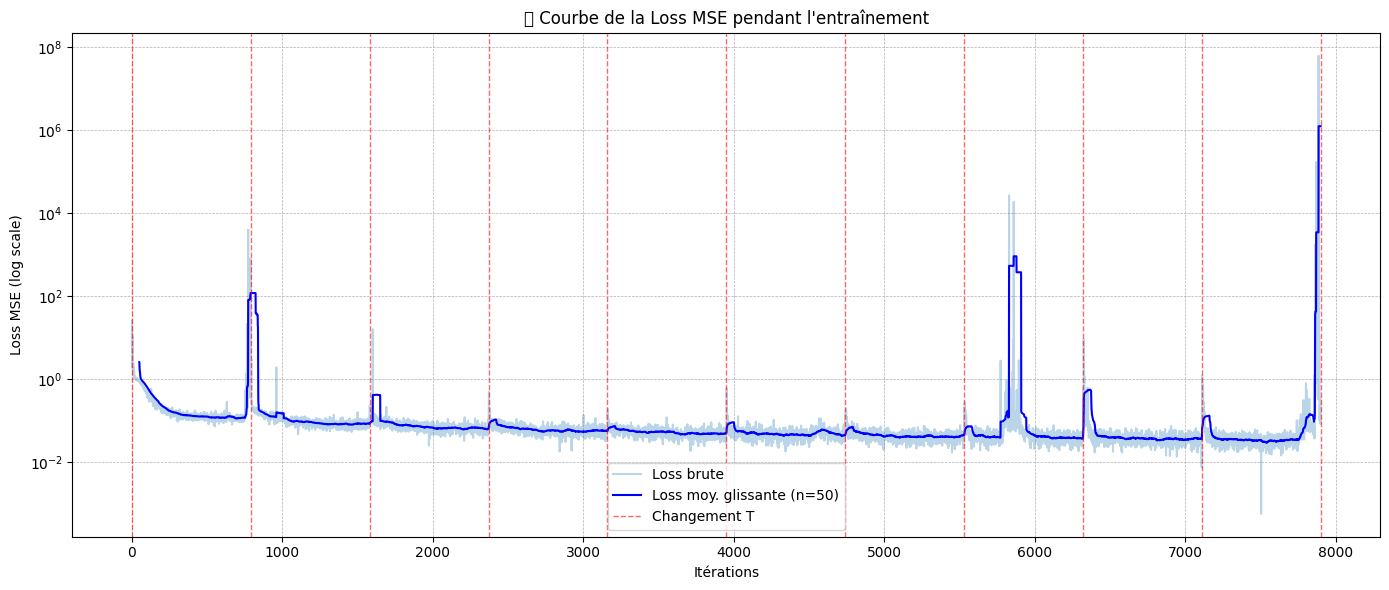

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))

# Paramètres
window = 50  # Moyenne glissante
iterations_per_epoch = len(dataloader)  # nombre d'itérations pour 1 epoch

# Moyenne glissante
smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')

# Courbes
plt.plot(losses, alpha=0.3, label="Loss brute")
plt.plot(range(window - 1, len(losses)), smoothed, color='blue', label=f"Loss moy. glissante (n={window})")

# Échelle log pour la lisibilité
plt.yscale("log")

# Lignes verticales aux changements de T (epochs multiples de 10)
max_epoch = len(losses) // iterations_per_epoch
for e in range(0, max_epoch + 1, 10):
    x = e * iterations_per_epoch
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1, alpha=0.6, label='Changement T' if e == 0 else None)

# Légendes & axes
plt.xlabel("Itérations")
plt.ylabel("Loss MSE (log scale)")
plt.title("📉 Courbe de la Loss MSE pendant l'entraînement")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


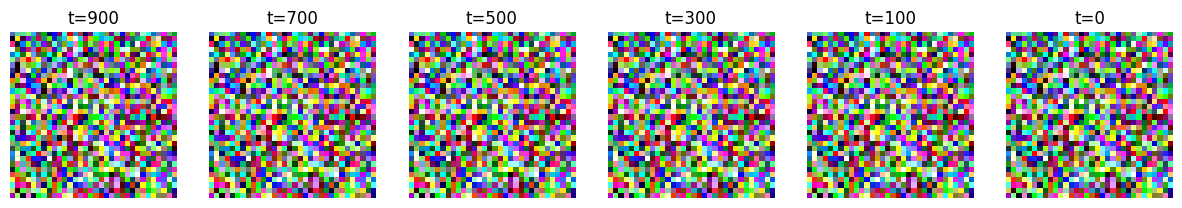

In [12]:
# Générer une image à t=900 (bruit très fort) jusqu'à t=0 (propre)
import matplotlib.pyplot as plt

t_test = [900, 700, 500, 300, 100, 0]

fig, axs = plt.subplots(1, len(t_test), figsize=(15, 3))
model.eval()
x = torch.randn(1, 3, 32, 32).to(device)

for i, t_val in enumerate(t_test):
    t_tensor = torch.tensor([t_val], device=device)
    x_t = diffusion.p_sample(x, t_tensor, y=torch.tensor([0], device=device))
    axs[i].imshow(((x_t.squeeze().detach().cpu().clamp(-1, 1) + 1) / 2).permute(1, 2, 0))
    axs[i].axis("off")
    axs[i].set_title(f"t={t_val}")
plt.show()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

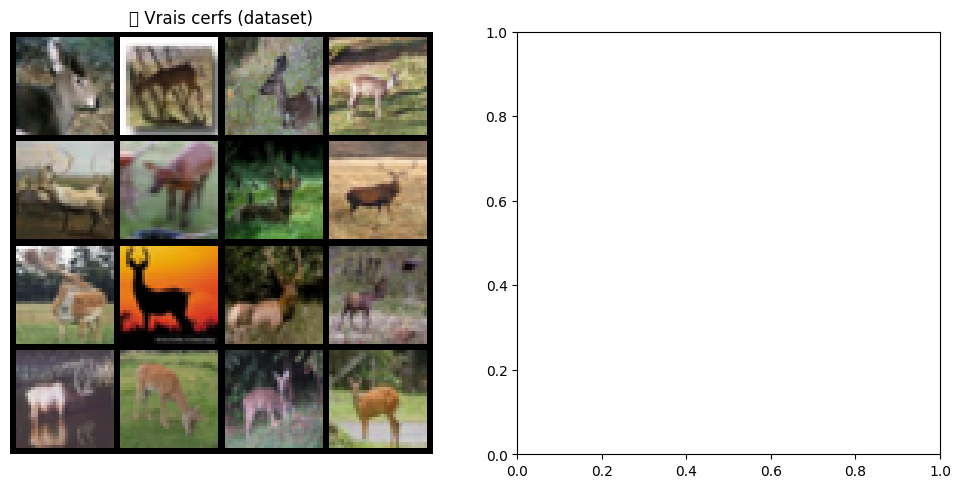

In [13]:
import matplotlib.pyplot as plt
import torchvision

# 🔹 1. Affichage d'un batch d'images réelles (cerfs)
real_images, real_labels = next(iter(dataloader))
real_images = (real_images * 0.5) + 0.5  # Dé-normaliser [-1,1] → [0,1]
real_grid = torchvision.utils.make_grid(real_images[:16], nrow=4)

# 🔹 2. Génération d'un batch de cerfs synthétiques
model.eval()
with torch.no_grad():
    y_sample = torch.zeros(16, dtype=torch.long, device=device)  # Tous cerfs (label 0)
    fake_images = diffusion.sample(batch_size=16, image_size=image_size, y=y_sample)
    fake_images = (fake_images.clamp(-1, 1) + 1) / 2
    fake_grid = torchvision.utils.make_grid(fake_images, nrow=4)

# 🔹 3. Affichage
plt.figure(figsize=(12, 6))

# Vraies images
plt.subplot(1, 2, 1)
plt.imshow(real_grid.permute(1, 2, 0))
plt.title("📸 Vrais cerfs (dataset)")
plt.axis("off")

# Générées
plt.subplot(1, 2, 2)
plt.imshow(fake_grid.permute(1, 2, 0))
plt.title("🎨 Cerfs générés (DDPM)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
from tqdm.notebook import tqdm
import torch.nn.utils

start_epoch = 100
epochs = 150  
timestep_final = 1000
current_max_sample_t = 1000  # 🔁 à l'epoch 95, t allait jusqu'à 998
lr = 2e-4

# ✅ Recharger modèle
model = UNetConditional(in_channels=3, base_channels=64, time_emb_dim=256, class_emb_dim=128, num_classes=num_classes).to(device)
model.load_state_dict(torch.load("model_epoch_100.pt", map_location=device))
print("✅ Modèle chargé depuis model_epoch_100.pt")

# 🔁 Créer diffusion avec T=1000
diffusion = GaussianDiffusion(model, timesteps=timestep_final, device=device)

# 🔄 Optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []

# 🔂 Boucle d'entraînement (suite)
for epoch in range(start_epoch, epochs + 1):
    model.train()
    epoch_losses = []

    loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs} | Timesteps: {diffusion.timesteps} | Sample t ∈ [0,{current_max_sample_t})")

    for x, y in loop:
        x, y = x.to(device), y.to(device)
        t = torch.randint(0, min(current_max_sample_t, diffusion.timesteps - 1), (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = diffusion.q_sample(x, t, noise)

        noise_pred = model(x_t, t, y)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # stabilisation
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        epoch_losses.append(loss.item())
        losses.append(loss.item())  # 👈 tu peux garder la liste si tu veux tracer après

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"🔁 Epoch {epoch} terminé — Moyenne loss : {avg_loss:.4f}")

    # 🔼 Progression douce vers T
    if epoch == 96:
        current_max_sample_t = 999
    elif epoch == 97:
        current_max_sample_t = 1000
    elif epoch >= 98:
        current_max_sample_t = min(current_max_sample_t, diffusion.timesteps - 1)

    # 🖼️ Échantillonnage toutes les 5 epochs
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            y_sample = torch.tensor([0] * 16, device=device)
            samples = diffusion.sample(batch_size=16, image_size=image_size, y=y_sample)
            save_sample_grid(samples, os.path.join(save_dir, f"sample_epoch_{epoch}.png"), nrow=4)
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pt"))
            print(f"📸 Échantillons + modèle sauvegardés (epoch {epoch}) dans {save_dir}")


✅ Modèle chargé depuis model_epoch_100.pt
🔧 Diffusion mise à jour : 1000 étapes


Epoch 100/150 | Timesteps: 1000 | Sample t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 100 terminé — Moyenne loss : 0.1057
📸 Échantillons + modèle sauvegardés (epoch 100) dans results


Epoch 101/150 | Timesteps: 1000 | Sample t ∈ [0,999):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 101 terminé — Moyenne loss : 0.0357


Epoch 102/150 | Timesteps: 1000 | Sample t ∈ [0,999):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 102 terminé — Moyenne loss : 0.0327


Epoch 103/150 | Timesteps: 1000 | Sample t ∈ [0,999):   0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
from tqdm.notebook import tqdm
import torch.nn.utils

# ⚙️ Paramètres
start_epoch = 100
epochs = 150
timestep_final = 1000
lr = 2e-4
losses = []

current_max_sample_t = 1000


# ✅ Recharger modèle depuis epoch 100
model = UNetConditional(in_channels=3, base_channels=64, time_emb_dim=256, class_emb_dim=128, num_classes=num_classes).to(device)
model.load_state_dict(torch.load("model_epoch_100.pt", map_location=device))
print("✅ Modèle chargé depuis model_epoch_100.pt")

# 🌀 Diffusion avec T=1000
diffusion = GaussianDiffusion(model, timesteps=timestep_final, device=device)

# Optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 🔁 Boucle d'entraînement
for epoch in range(start_epoch, epochs + 1):
    model.train()
    epoch_losses = []

    loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs} | Timesteps: {diffusion.timesteps} | t ∈ [0,{current_max_sample_t})")

    for x, y in loop:
        x, y = x.to(device), y.to(device)
        t = torch.randint(0, current_max_sample_t, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = diffusion.q_sample(x, t, noise)

        noise_pred = model(x_t, t, y)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # stabilisation
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        epoch_losses.append(loss.item())
        losses.append(loss.item())  # utile pour ta courbe

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"🔁 Epoch {epoch} terminé — Moyenne loss : {avg_loss:.4f}")

    # 🖼️ Échantillons & modèle
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            y_sample = torch.tensor([0] * 16, device=device)
            samples = diffusion.sample(batch_size=16, image_size=image_size, y=y_sample)
            save_sample_grid(samples, os.path.join(save_dir, f"sample_epoch_{epoch}.png"), nrow=4)
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pt"))
            print(f"📸 Échantillons + modèle sauvegardés (epoch {epoch}) dans {save_dir}")



✅ Modèle chargé depuis model_epoch_100.pt
🔧 Diffusion mise à jour : 1000 étapes


Epoch 100/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 100 terminé — Moyenne loss : 0.0898
📸 Échantillons + modèle sauvegardés (epoch 100) dans results


Epoch 101/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 101 terminé — Moyenne loss : 0.0333


Epoch 102/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 102 terminé — Moyenne loss : 0.0351


Epoch 103/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 103 terminé — Moyenne loss : 0.0316


Epoch 104/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 104 terminé — Moyenne loss : 0.0331


Epoch 105/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 105 terminé — Moyenne loss : 0.0353
📸 Échantillons + modèle sauvegardés (epoch 105) dans results


Epoch 106/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 106 terminé — Moyenne loss : 0.0744


Epoch 107/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 107 terminé — Moyenne loss : 0.0572


Epoch 108/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 108 terminé — Moyenne loss : 0.0356


Epoch 109/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 109 terminé — Moyenne loss : 0.0355


Epoch 110/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 110 terminé — Moyenne loss : 0.0329
📸 Échantillons + modèle sauvegardés (epoch 110) dans results


Epoch 111/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 111 terminé — Moyenne loss : 0.0321


Epoch 112/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 112 terminé — Moyenne loss : 0.0324


Epoch 113/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 113 terminé — Moyenne loss : 0.0350


Epoch 114/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 114 terminé — Moyenne loss : 0.0320


Epoch 115/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 115 terminé — Moyenne loss : 0.0343
📸 Échantillons + modèle sauvegardés (epoch 115) dans results


Epoch 116/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 116 terminé — Moyenne loss : 0.0325


Epoch 117/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 117 terminé — Moyenne loss : 0.0330


Epoch 118/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 118 terminé — Moyenne loss : 0.0325


Epoch 119/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 119 terminé — Moyenne loss : 0.0321


Epoch 120/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 120 terminé — Moyenne loss : 0.0359
📸 Échantillons + modèle sauvegardés (epoch 120) dans results


Epoch 121/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 121 terminé — Moyenne loss : 0.0513


Epoch 122/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 122 terminé — Moyenne loss : 495236.1278


Epoch 123/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 123 terminé — Moyenne loss : 23324.8529


Epoch 124/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 124 terminé — Moyenne loss : 4.0262


Epoch 125/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 125 terminé — Moyenne loss : 4.3499
📸 Échantillons + modèle sauvegardés (epoch 125) dans results


Epoch 126/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 126 terminé — Moyenne loss : 0.0617


Epoch 127/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 127 terminé — Moyenne loss : 0.0478


Epoch 128/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 128 terminé — Moyenne loss : 0.0471


Epoch 129/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 129 terminé — Moyenne loss : 0.0442


Epoch 130/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 130 terminé — Moyenne loss : 0.0451
📸 Échantillons + modèle sauvegardés (epoch 130) dans results


Epoch 131/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 131 terminé — Moyenne loss : 0.0421


Epoch 132/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 132 terminé — Moyenne loss : 0.0434


Epoch 133/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 133 terminé — Moyenne loss : 0.0394


Epoch 134/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 134 terminé — Moyenne loss : 0.0414


Epoch 135/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 135 terminé — Moyenne loss : 0.0376
📸 Échantillons + modèle sauvegardés (epoch 135) dans results


Epoch 136/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 136 terminé — Moyenne loss : 0.0371


Epoch 137/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 137 terminé — Moyenne loss : 0.0370


Epoch 138/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 138 terminé — Moyenne loss : 0.0362


Epoch 139/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 139 terminé — Moyenne loss : 0.0374


Epoch 140/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 140 terminé — Moyenne loss : 0.0339
📸 Échantillons + modèle sauvegardés (epoch 140) dans results


Epoch 141/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 141 terminé — Moyenne loss : 0.0383


Epoch 142/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 142 terminé — Moyenne loss : 0.0348


Epoch 143/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 143 terminé — Moyenne loss : 0.0346


Epoch 144/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 144 terminé — Moyenne loss : 0.0357


Epoch 145/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 145 terminé — Moyenne loss : 0.0362
📸 Échantillons + modèle sauvegardés (epoch 145) dans results


Epoch 146/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 146 terminé — Moyenne loss : 0.0361


Epoch 147/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 147 terminé — Moyenne loss : 0.0357


Epoch 148/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 148 terminé — Moyenne loss : 0.0359


Epoch 149/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 149 terminé — Moyenne loss : 0.0366


Epoch 150/150 | Timesteps: 1000 | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 150 terminé — Moyenne loss : 0.0347
📸 Échantillons + modèle sauvegardés (epoch 150) dans results


In [8]:
start_epoch = 111
epochs = 150  # ou plus si tu veux pousser encore un peu
timestep_final = 1000
current_max_sample_t = 1000  #  éviter t=999 qui est trop bruité
lr_finetune = lr * 0.5 


# Charger le modèle
model = UNetConditional(in_channels=3, base_channels=64, time_emb_dim=256, class_emb_dim=128, num_classes=num_classes).to(device)
model.load_state_dict(torch.load("model_epoch_110.pt", map_location=device))
print("Modèle rechargé depuis model_epoch_110.pt")

# Remettre la diffusion avec T=1000
diffusion = GaussianDiffusion(model, timesteps=timestep_final, device=device)

# Nouvel optimiseur avec learning rate réduit
optimizer = torch.optim.Adam(model.parameters(), lr=lr_finetune)

# Boucle d'entraînement stable
for epoch in range(start_epoch, epochs + 1):
    model.train()
    epoch_losses = []

    loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs} | Finetune | t ∈ [0,{current_max_sample_t})")
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        t = torch.randint(0, current_max_sample_t, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = diffusion.q_sample(x, t, noise)

        noise_pred = model(x_t, t, y)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        epoch_losses.append(loss.item())
        losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"🔁 Epoch {epoch} terminé — Moyenne loss : {avg_loss:.4f}")

    # 📸 Sauvegarde
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            y_sample = torch.tensor([0] * 16, device=device)
            samples = diffusion.sample(batch_size=16, image_size=image_size, y=y_sample)
            save_sample_grid(samples, os.path.join(save_dir, f"sample_epoch_{epoch}.png"), nrow=4)
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pt"))
            print(f"📸 Sauvegarde modèle + échantillons (epoch {epoch}) dans {save_dir}")


Modèle rechargé depuis model_epoch_110.pt
🔧 Diffusion mise à jour : 1000 étapes


Epoch 111/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 111 terminé — Moyenne loss : 0.0362


Epoch 112/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 112 terminé — Moyenne loss : 0.0331


Epoch 113/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 113 terminé — Moyenne loss : 0.0324


Epoch 114/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 114 terminé — Moyenne loss : 0.0322


Epoch 115/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 115 terminé — Moyenne loss : 0.0319
📸 Sauvegarde modèle + échantillons (epoch 115) dans results


Epoch 116/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 116 terminé — Moyenne loss : 0.0313


Epoch 117/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 117 terminé — Moyenne loss : 0.0298


Epoch 118/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 118 terminé — Moyenne loss : 0.0319


Epoch 119/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 119 terminé — Moyenne loss : 0.0320


Epoch 120/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 120 terminé — Moyenne loss : 0.0330
📸 Sauvegarde modèle + échantillons (epoch 120) dans results


Epoch 121/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 121 terminé — Moyenne loss : 0.0325


Epoch 122/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 122 terminé — Moyenne loss : 0.0331


Epoch 123/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 123 terminé — Moyenne loss : 0.0326


Epoch 124/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 124 terminé — Moyenne loss : 0.0339


Epoch 125/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 125 terminé — Moyenne loss : 0.0343
📸 Sauvegarde modèle + échantillons (epoch 125) dans results


Epoch 126/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 126 terminé — Moyenne loss : 0.0325


Epoch 127/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 127 terminé — Moyenne loss : 0.0318


Epoch 128/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 128 terminé — Moyenne loss : 0.0320


Epoch 129/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 129 terminé — Moyenne loss : 0.0324


Epoch 130/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 130 terminé — Moyenne loss : 0.0327
📸 Sauvegarde modèle + échantillons (epoch 130) dans results


Epoch 131/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 131 terminé — Moyenne loss : 0.0324


Epoch 132/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 132 terminé — Moyenne loss : 0.0332


Epoch 133/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 133 terminé — Moyenne loss : 0.0329


Epoch 134/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 134 terminé — Moyenne loss : 0.0317


Epoch 135/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 135 terminé — Moyenne loss : 0.0324
📸 Sauvegarde modèle + échantillons (epoch 135) dans results


Epoch 136/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 136 terminé — Moyenne loss : 0.0305


Epoch 137/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 137 terminé — Moyenne loss : 0.0330


Epoch 138/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 138 terminé — Moyenne loss : 0.0332


Epoch 139/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 139 terminé — Moyenne loss : 0.0318


Epoch 140/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 140 terminé — Moyenne loss : 0.0324
📸 Sauvegarde modèle + échantillons (epoch 140) dans results


Epoch 141/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 141 terminé — Moyenne loss : 0.0330


Epoch 142/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 142 terminé — Moyenne loss : 0.0330


Epoch 143/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 143 terminé — Moyenne loss : 0.0322


Epoch 144/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 144 terminé — Moyenne loss : 0.0321


Epoch 145/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 145 terminé — Moyenne loss : 0.0330
📸 Sauvegarde modèle + échantillons (epoch 145) dans results


Epoch 146/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 146 terminé — Moyenne loss : 0.0318


Epoch 147/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 147 terminé — Moyenne loss : 0.0334


Epoch 148/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 148 terminé — Moyenne loss : 0.0329


Epoch 149/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 149 terminé — Moyenne loss : 0.0309


Epoch 150/150 | Finetune | t ∈ [0,1000):   0%|          | 0/79 [00:00<?, ?it/s]

🔁 Epoch 150 terminé — Moyenne loss : 0.0326
📸 Sauvegarde modèle + échantillons (epoch 150) dans results


C:\Users\mbell\AppData\Local\Temp\ipykernel_50124\690006229.py:27: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mbell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


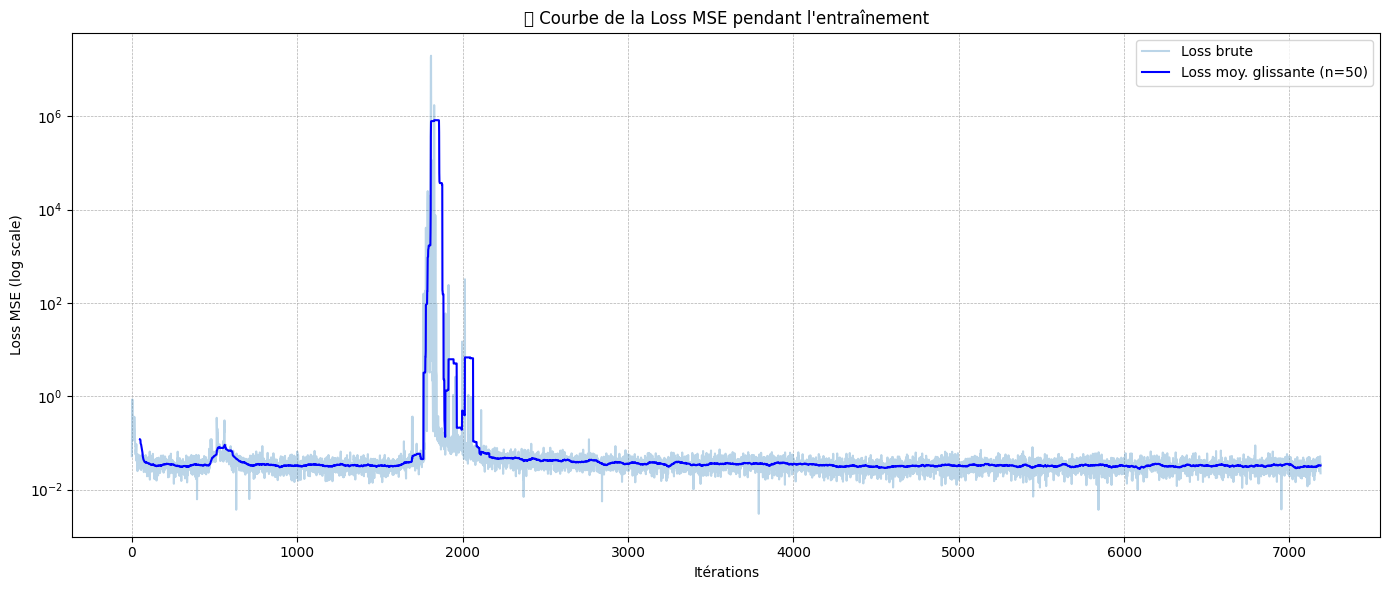

In [9]:
#courbe de loss en logarithmique
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))

# Paramètres
window = 50  # Moyenne glissante
iterations_per_epoch = len(dataloader)  # nombre d'itérations pour 1 epoch

# Moyenne glissante
smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')

# Courbes
plt.plot(losses, alpha=0.3, label="Loss brute")

plt.plot(range(window - 1, len(losses)), smoothed, color='blue', label=f"Loss moy. glissante (n={window})")

# Échelle log pour la lisibilité
plt.yscale("log")
# Légendes & axes
plt.xlabel("Itérations")
plt.ylabel("Loss MSE (log scale)")
plt.title("📉 Courbe de la Loss MSE pendant l'entraînement")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

